In [1]:
import matplotlib.pyplot as plt
import itertools
import hoomd
import math

import xarray as xr
import numpy
import gsd.hoomd
import sphere_fres as sf


In [2]:
# build simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=0)
sim.create_state_from_gsd(filename='sheet.gsd')

#simulation parameters
initial_kT = 0.01

In [3]:
kf_delta_deg = 10  # half-opening angle of patches
kf_epsilon = 1.0  # strength of patchy interaction in kT
kf_lambda = 4.0  # range of patchy interaction
sigma = 4.0  # hard core diameter

q_angle = [math.cos(math.pi*(1/4)), 0, 0, math.sin(math.pi*(1/4))]

#E_long site parameters
a_long = 4.5
b_long = 10
r_long = 13

a_lat = 6.3
b_lat = 8.0
r_lat = 8


mc = hoomd.hpmc.integrate.Sphere(default_d=0.5, default_a=0.8)
mc.shape['A'] = dict(diameter=sigma, orientable=True)
sim.operations.integrator = mc

patch_code = f"""

const float delta = {kf_delta_deg} * M_PI / 180;  // delta in radians
const float epsilon = {kf_epsilon:f};
const float lambda = {kf_lambda:f};
const float sigma = {sigma:f};  // hard core diameter

const float a_o = {a_long};
const float b_o = {b_long};
const float r_o = {r_long};

const float a_a = {a_lat};
const float b_a = {b_lat};
const float r_a = {r_lat};


const float kT = param_array[0];

const const vec3<float> temp(0, 0, sqrtf(2)/2);
const quat<float> q_perp(sqrtf(2)/2,temp);

const vec3<float> ehat_particle_reference_frame(1, 0, 0);
vec3<float> ehat_i = rotate(q_i, ehat_particle_reference_frame);
vec3<float> ehat_j = rotate(q_j, ehat_particle_reference_frame);

vec3<float> ehat_i_p = rotate(q_perp*q_i, ehat_particle_reference_frame);
vec3<float> ehat_j_p = rotate(q_perp*q_j, ehat_particle_reference_frame);

vec3<float> r_hat_ij = r_ij / sqrtf(dot(r_ij, r_ij));
bool patch_on_i_is_aligned_with_r_ij = dot(ehat_i, r_hat_ij) >= cos(delta);
bool patch_on_j_is_aligned_with_r_ji = dot(ehat_j, -r_hat_ij) >= cos(delta);
bool patch_on_i_is_aligned_with_r_ji = dot(ehat_i, -r_hat_ij) >= cos(delta);
bool patch_on_j_is_aligned_with_r_ij = dot(ehat_j, r_hat_ij) >= cos(delta);

bool patch_on_i_is_perpendicular_r_ij = abs(dot(ehat_i_p, r_hat_ij)) >= cos(delta);
bool patch_on_j_is_perpendiculat_r_ij = abs(dot(ehat_j_p, r_hat_ij)) >= cos(delta);

float rsq = dot(r_ij, r_ij);
float r_ij_length = sqrtf(rsq);
float r_ij_ls = r_ij_length - sigma;
if ((patch_on_i_is_aligned_with_r_ij || patch_on_i_is_aligned_with_r_ji)
    && (patch_on_j_is_aligned_with_r_ji || patch_on_j_is_aligned_with_r_ij)
    && r_ij_length < lambda*sigma)
    {{
    return ((a_o* pow(r_ij_ls/r_o,2)*exp(-r_ij_ls/r_o))
        -b_o*exp(-(pow(r_ij_ls/r_o,2))) ) / kT;
    }}
else if (patch_on_i_is_perpendicular_r_ij
         && patch_on_j_is_perpendiculat_r_ij
         && r_ij_length < lambda*sigma)
    {{
    return ((a_a* pow(r_ij_ls/r_a,2)*exp(-r_ij_ls/r_a))
    -b_a*exp(-(pow(r_ij_ls/r_a,2))) ) / kT;      
    }}
else
    {{
    return 0.0;
    }}
"""

In [4]:
r_cut = sigma + sigma * (kf_lambda - 1)
patch_param_array = [initial_kT]

patch_potential = hoomd.hpmc.pair.user.CPPPotential(r_cut=r_cut,
                                                    code=patch_code,
                                                    param_array=patch_param_array)

mc.pair_potential = patch_potential
sim.run(0000)
print(patch_potential.energy)

-132915.6875


In [5]:
logger = hoomd.logging.Logger()
logger.add(patch_potential, quantities=[
    'energy',
])
logger[('kT',)] = (lambda: patch_potential.param_array[0], 'scalar')
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(50),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             logger=logger)
sim.operations.writers.append(gsd_writer)


In [6]:
sim.run(30000)


In [7]:
gsd_writer.flush()

data = gsd.hoomd.read_log('log.gsd')
step = data['configuration/step']

beta_potential_energy = data['log/hpmc/pair/user/CPPPotential/energy']
kT = data['log/kT']
potential_energy = beta_potential_energy * kT


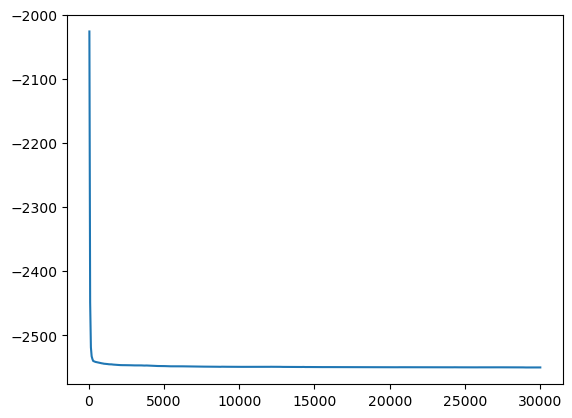

In [8]:
plt.figure(1)
plt.plot(step,potential_energy)

In [9]:
with sim.state.cpu_local_snapshot as sn:
    #print(sn.particles.position)
    N_particles = max(sn.particles.tag)
    distlog = numpy.array([])
    neighborlist = numpy.array([])
    for i in range(N_particles):
        for j in range(i+1,N_particles):
            displacement = sn.particles.position[i,:]- sn.particles.position[j,:]
            temp_dist = math.sqrt(numpy.dot(displacement, displacement))
            distlog = numpy.append(distlog,temp_dist)
            if temp_dist <= 10:
                neighborlist = numpy.append(neighborlist,[int(i),int(j)])
    dist =sn.particles.position[0,:]- sn.particles.position[1,:]
    #print(math.sqrt(numpy.dot(dist, dist)))

Text(0.5, 0, 'Distance / 10^(-10)m')

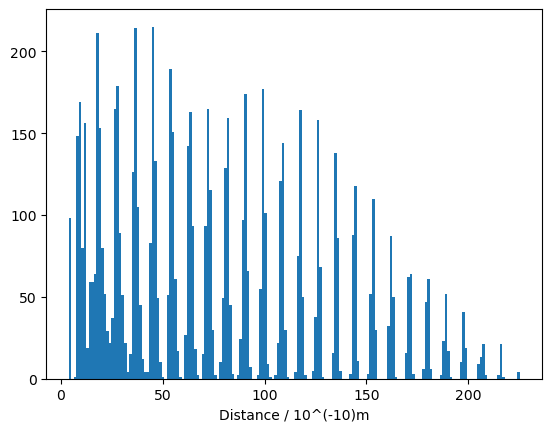

In [10]:
plt.figure(2)
plt.hist(distlog,bins=int(numpy.max(distlog)*0.8))
plt.xlabel('Distance / 10^(-10)m')


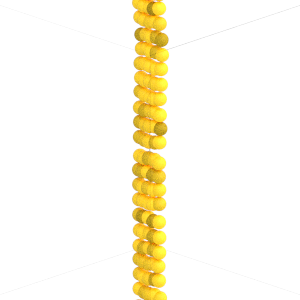

In [11]:
sf.render(sim.state.get_snapshot(),120*1.4)

In [12]:
neighborlist=numpy.reshape(neighborlist,(int(numpy.size(neighborlist)/2),2) ) 


In [13]:
neighborlist[int(numpy.size(neighborlist)/2)-1,:]



array([122., 123.])

In [14]:
with sim.state.cpu_local_snapshot as sn:
    angle_distlog = numpy.array([])
    for i in range(0,int(numpy.size(neighborlist)/2)):
        P1 = int(neighborlist[i,0])
        P2 = int(neighborlist[i,1])
        Q1 = numpy.array(sn.particles.orientation[P1,:])
        Q2 = numpy.array(sn.particles.orientation[P2,:])
        in_prod = numpy.sum(Q1*Q2)
        Angle_dist = math.acos( 2*(in_prod)**2-1)
        angle_distlog = numpy.append(angle_distlog,Angle_dist)

        

(array([30., 31., 30., 29., 38., 42., 26., 25., 37., 41., 36., 26.]),
 array([0.04533743, 0.30331378, 0.56129013, 0.81926647, 1.07724282,
        1.33521917, 1.59319552, 1.85117187, 2.10914822, 2.36712457,
        2.62510091, 2.88307726, 3.14105361]),
 <BarContainer object of 12 artists>)

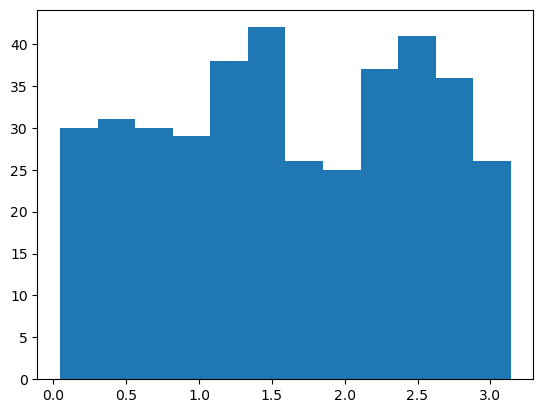

In [15]:
plt.figure(23)
plt.hist(angle_distlog,bins=12)

(array([  0.,   0.,   0., 198.,   0.,   0.,   0., 193.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

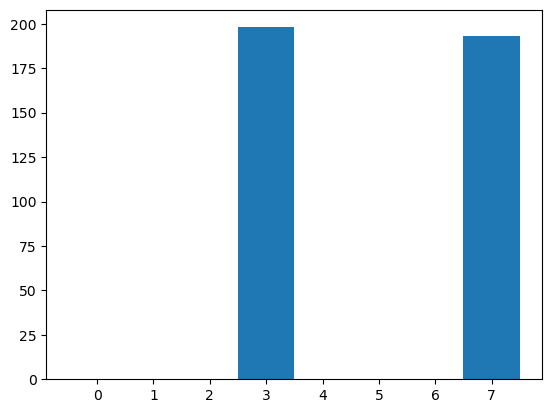

In [16]:
import quat_mult as qm

with sim.state.cpu_local_snapshot as sn:
    #angle_distlog = numpy.array([])
    indexlog = numpy.array([])
    for i in range(0,int(numpy.size(neighborlist)/2)):
        P1 = int(neighborlist[i,0])
        P2 = int(neighborlist[i,1])
        Q1 = numpy.array(sn.particles.orientation[P1,:])
        Q2 = numpy.array(sn.particles.orientation[P2,:])
        in_prod = numpy.sum(Q1*Q2)
        #Angle_dist = math.acos( 2*(in_prod)**2-1)
        #angle_distlog = numpy.append(angle_distlog,Angle_dist)
        
        Q1_conj = numpy.array([Q1[0], -Q1[1],-Q1[2],-Q1[3]])
        
        Q_rel = qm.quaternion_multiply(Q2,Q1_conj)
        
        angles=numpy.array([0.,1.,2.])

        sinr_cosp = 2 * (Q_rel[0] * Q_rel[1] + Q_rel[2] * Q_rel[3]);
        cosr_cosp = 1 - 2 * (Q_rel[1] * Q_rel[1] + Q_rel[2] * Q_rel[2]);
        angles[0] = math.atan2(sinr_cosp, cosr_cosp);

        sinp = math.sqrt(1 + 2 * (Q_rel[0] * Q_rel[2] - Q_rel[1] * Q_rel[3]));
        cosp = math.sqrt(1 - 2 * (Q_rel[0] * Q_rel[2] - Q_rel[1] * Q_rel[3]));
        angles[1] = 2 * math.atan2(sinp, cosp) - math.pi / 2;


        siny_cosp = 2 * (Q_rel[0] * Q_rel[3] + Q_rel[1] * Q_rel[2]);
        cosy_cosp = 1 - 2 * (Q_rel[2] * Q_rel[2] + Q_rel[3] * Q_rel[3]);
        angles[2] = math.atan2(siny_cosp, cosy_cosp);

        a=round((-abs(angles[0])/math.pi)+1);
        b=round((-(2*abs(angles[1]))/math.pi)+1) ;
        c=round((-abs(angles[2])/math.pi)+1);
        
        indexlog=numpy.append(indexlog,[a*4+b*2+c])


max(angle_distlog)


plt.figure(4)
plt.hist(indexlog,bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])

In [17]:
neighborlist.astype(int)

#create triplets
triplet=numpy.array([])
for i in range(int(numpy.size(neighborlist)/2)):
        for j in range(i+1,int(numpy.size(neighborlist)/2)):
            tpair1 = numpy.array(neighborlist[i,:])
            tpair2 = numpy.array(neighborlist[j,:])
            temp_triplet = numpy.unique( numpy.concatenate((tpair1,tpair2 )) )
            if numpy.size(temp_triplet) == 3:
                triplet=numpy.append(triplet, temp_triplet)
#triplet

In [18]:
triplet = numpy.reshape(triplet,(int(numpy.size(triplet)/3),3) ) 
triplet = numpy.unique(triplet,axis=0) #remove double counted triplets

with sim.state.cpu_local_snapshot as sn:
    v_angle_log = numpy.array([])
    for i in range(0,int(numpy.size(triplet)/3)):
        I1 = int(triplet[i,0])
        I2 = int(triplet[i,1])
        I3 = int(triplet[i,2])
        Pos1 = numpy.array(sn.particles.position[I1,:])
        Pos2 = numpy.array(sn.particles.position[I2,:])
        Pos3 = numpy.array(sn.particles.position[I3,:])
        V1 = Pos1-Pos2
        V2 = Pos2-Pos3
        V3 = Pos3-Pos1
        sz1 = math.sqrt(abs(numpy.dot(V1,V1)))
        sz2 = math.sqrt(abs(numpy.dot(V2,V2)))
        sz3 = math.sqrt(abs(numpy.dot(V3,V3)))
        if sz1>sz2 and sz1>sz3:
            v_angle_log = numpy.append( v_angle_log , math.acos(numpy.dot(V2,V3)/(sz2*sz3)) )
        elif sz2>sz1 and sz2>sz3:
            v_angle_log = numpy.append( v_angle_log , math.acos(numpy.dot(V1,V3)/(sz1*sz3)) )
        elif sz3>sz2 and sz3>sz1:
            v_angle_log = numpy.append( v_angle_log , math.acos(numpy.dot(V1,V2)/(sz1*sz2)) )

(array([113.,  50., 145., 221., 113.,  17.,   0.,  12.,  52.,  55.,  71.,
         76.,  68., 106., 228., 268., 256., 194.,  67., 167.]),
 array([0.00953901, 0.10998785, 0.21043669, 0.31088553, 0.41133436,
        0.5117832 , 0.61223204, 0.71268088, 0.81312972, 0.91357856,
        1.0140274 , 1.11447624, 1.21492508, 1.31537392, 1.41582276,
        1.5162716 , 1.61672044, 1.71716928, 1.81761812, 1.91806696,
        2.01851579]),
 <BarContainer object of 20 artists>)

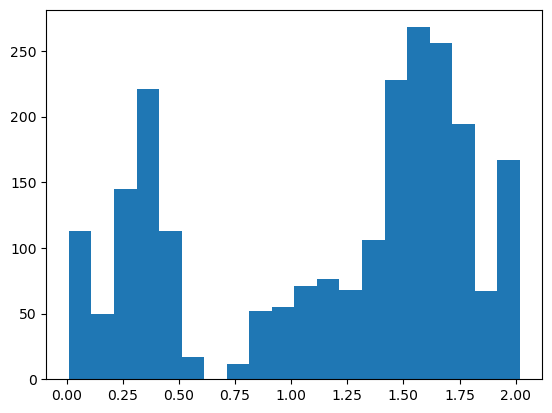

In [19]:
plt.figure(5)
plt.hist(v_angle_log,bins=20)
#Spike at 2 radians indicates equilateral triangles